In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import math
import torch
from torch.nn.modules.transformer import TransformerEncoder, TransformerEncoderLayer
from torch.nn.modules import LayerNorm, Linear, ReLU
import torch.nn as nn
import torch.nn.functional as F
import sklearn.metrics
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pickle
from torch.utils.data import DataLoader



device = 'cuda' if torch.cuda.is_available() else 'cpu'


# Data Loader

In [62]:
X = np.load('/kaggle/input/active-learning-subset/tar_image_subset.npy') 
y = np.load('/kaggle/input/active-learning-subset/label_target_subset.npy')


X_pool, X_val, y_pool, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X_pool, y_pool, test_size=0.95, stratify=y_pool, random_state=42)


print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"X_labeled shape: {X_labeled.shape}")
print(f"y_labeled shape: {y_labeled.shape}")
print(f"X_unlabeled shape: {X_unlabeled.shape}")
print(f"y_unlabeled shape: {y_unlabeled.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val  shape: {y_val .shape}")


X shape: (20000, 6, 28)
y shape: (20000,)
X_labeled shape: (800, 6, 28)
y_labeled shape: (800,)
X_unlabeled shape: (15200, 6, 28)
y_unlabeled shape: (15200,)
X_val shape: (4000, 6, 28)
y_val  shape: (4000,)


In [63]:
y_sample = y_val
X_sample = X_val

# Label distribution
label_counts = Counter(y_sample)
df_labels = pd.DataFrame.from_dict(label_counts, orient='index').sort_index()
df_labels.columns = ['count']
df_labels['percent'] = 100 * df_labels['count'] / len(y_sample)
print("\nLabel distribution:")
print(df_labels)

channel_variance = np.var(X_sample, axis=2).mean(axis=0)
channel_mean = X_sample.mean(axis=(0, 2))
channel_std = X_sample.std(axis=(0, 2))
df_stats = pd.DataFrame({
    'channel': range(6),
    'mean': channel_mean,
    'std_dev': channel_std,
    'variance': channel_variance
})
print("\nMean, Std Dev and Variance per Channel:")
print(df_stats)


Label distribution:
   count  percent
0   1816   45.400
1    521   13.025
2   1663   41.575

Mean, Std Dev and Variance per Channel:
   channel      mean   std_dev  variance
0        0  0.009762  0.997754  0.730740
1        1  0.011106  0.995511  0.719789
2        2  0.008543  0.997186  0.755344
3        3  0.008551  0.996257  0.782027
4        4  0.012396  0.999044  0.637619
5        5  0.009685  1.002726  0.733507


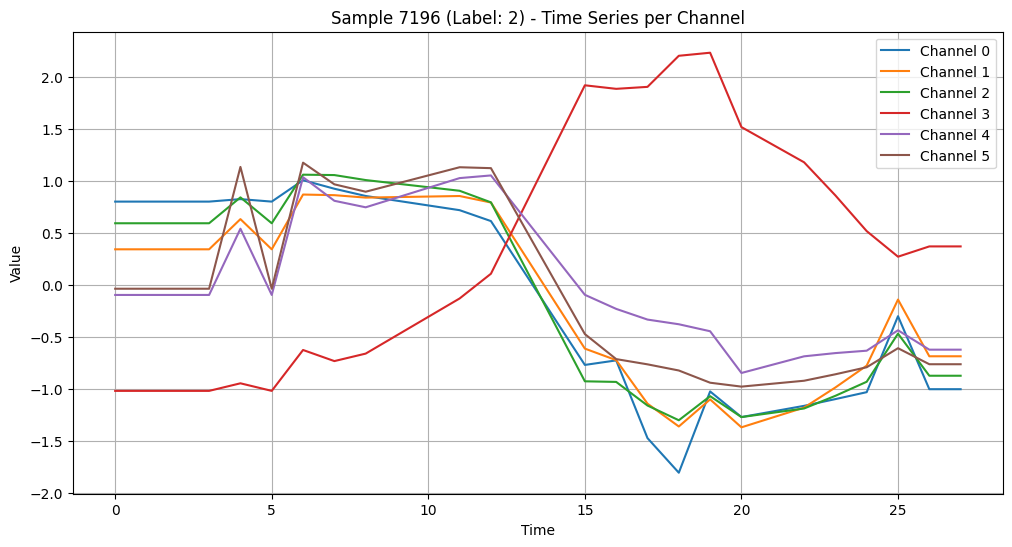

In [64]:
i = np.random.randint(0, len(X))
sample = X[i]  # Shape: (6, T)

plt.figure(figsize=(12, 6))
for c in range(6):
    plt.plot(sample[c], label=f'Channel {c}')
plt.title(f"Sample {i} (Label: {y[i]}) - Time Series per Channel")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

# Dataloader

In [65]:
class Dataset():
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __getitem__(self, index):
        return {
            "x": self.X[index],  # shape: [C, T]
            "y": self.y[index]
        }

    def __len__(self):
        return len(self.X)

In [66]:
labeled_dataset = Dataset(X_labeled, y_labeled)
unlabeled_dataset = Dataset(X_unlabeled, y_unlabeled)
val_dataset = Dataset(X_val, y_val)

# Model

In [67]:
################ CNN Backbone 
def conv_block(in_channels: int, out_channels: int) -> nn.Module:
    return nn.Sequential(
        nn.Conv1d(in_channels, out_channels, 5,padding='same'),
        nn.BatchNorm1d(out_channels),
        nn.ReLU(),
    )
 
class cnn(nn.Module):
    def __init__(self):
        super(cnn, self).__init__()
        self.conv1 = conv_block(6, 64)
        self.conv2 = conv_block(64, 128)
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 512)
        self.conv5 = conv_block(512, 1024)
        self.global_pool = nn.AdaptiveAvgPool1d((1))
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x=self.global_pool(x)
        x = x.view(x.size(0), -1)
        return x
 
################ Fully connected network
class FC(nn.Module):
    def __init__(self,input_dim):
        super(FC, self).__init__()
        self.fco = nn.Linear(input_dim, 3)
    def forward(self, x):
        x=self.fco(x)
        return x


class FullModel(nn.Module):
    def __init__(self, backbone, fc):
        super().__init__()
        self.backbone = backbone
        self.fc = fc

    def forward(self, x):
        feat = self.backbone(x)
        out = self.fc(feat)
        return feat, out

# Loading weights

In [68]:
#pretrained weights
map_location=torch.device(device)

backbone = cnn()
fc = FC(1024)

#loading backbone weights
state_dict = torch.load('/kaggle/input/active-learning-subset/backboneSiteA2019.pth', map_location=map_location)
# Remove "module." prefix
new_state_dict = {}
for k, v in state_dict.items():
    new_key = k.replace("module.", "")  # remove module. prefix
    new_state_dict[new_key] = v

backbone.load_state_dict(new_state_dict)

#loading fc weights
state_dict = torch.load('/kaggle/input/active-learning-subset/fcSiteA2019.pth', map_location=map_location)
# Remove "module." prefix
new_state_dict = {}
for k, v in state_dict.items():
    new_key = k.replace("module.", "")  # remove module. prefix
    new_state_dict[new_key] = v

fc.load_state_dict(new_state_dict)

model = FullModel(backbone, fc).to(device)

# Train/eval loop

In [69]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss, all_preds, all_targets = 0, [], []

    for batch in tqdm(dataloader, desc="Training", leave=False):
        x, y = batch["x"].to(device), batch["y"].to(device)

        optimizer.zero_grad()
        _, out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(x)
        preds = torch.argmax(out, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(y.cpu().numpy())

    avg_loss = total_loss / len(dataloader.dataset)
    acc = np.mean(np.array(all_preds) == np.array(all_targets))
    f1s = sklearn.metrics.f1_score(all_targets, all_preds, average=None)
    return avg_loss, acc, f1s, np.mean(f1s)



def _eval_perf(model, dataloader, device, criterion=None):
    model.eval()
    pred, gt = [], []
    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            x, y = batch["x"].to(device), batch["y"].to(device)
            _, outputs = model(x)
            preds = torch.argmax(outputs, dim=1)
            if criterion:
                total_loss += criterion(outputs, y).item() * len(x)

            pred.extend(preds.cpu().numpy())
            gt.extend(y.cpu().numpy())

    acc = np.mean(np.array(pred) == np.array(gt))
    f1s = sklearn.metrics.f1_score(gt, pred, average=None)
    avg_f1 = np.mean(f1s)

    if criterion:
        avg_loss = total_loss / len(dataloader.dataset)
        return avg_loss, f1s, acc, avg_f1
    else:
        return 0, f1s, acc, avg_f1



# Active Learning methods

In [70]:
def plot_round_metrics(history):
    round_id = len(history["epoch_metrics"]) - 1
    epoch_stats = history["epoch_metrics"][round_id]
    epochs = list(range(1, len(epoch_stats) + 1))

    train_loss = [e["train_loss"] for e in epoch_stats]
    val_loss = [e["val_loss"] for e in epoch_stats]
    train_acc = [e["train_acc"] for e in epoch_stats]
    train_f1 = [e["train_avg_f1"] for e in epoch_stats]
    val_acc = [e["val_acc"] for e in epoch_stats]
    val_f1 = [e["val_avg_f1"] for e in epoch_stats]

    plt.figure(figsize=(15, 4))

    # Loss plot
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Val Loss")
    plt.title(f"[Round {round_id+1}] Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_acc, label="Train Acc")
    plt.plot(epochs, val_acc, label="Val Acc")
    plt.title(f"[Round {round_id+1}] Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Avg F1 plot
    plt.subplot(1, 3, 3)
    plt.plot(epochs, train_f1, label="Train F1")
    plt.plot(epochs, val_f1, label="Val F1")
    plt.title(f"[Round {round_id+1}] Avg F1")
    plt.xlabel("Epoch")
    plt.ylabel("Avg F1")
    plt.legend()

    plt.tight_layout()
    plt.show()



def plot_final_performance(history):
    samples = history["samples"]
    val_acc = history["round_val_acc"]
    val_f1 = history["round_val_avg_f1"]

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(samples, val_acc, marker='o')
    plt.title("Val Accuracy vs Labeled Samples")
    plt.xlabel("Labeled Samples")
    plt.ylabel("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(samples, val_f1, marker='o')
    plt.title("Val Avg F1 vs Labeled Samples")
    plt.xlabel("Labeled Samples")
    plt.ylabel("Avg F1")

    plt.tight_layout()
    plt.show()


In [71]:
def query_samples(model, dataset, query_size, strategy, device):
    model.eval()
    dataloader = DataLoader(dataset, batch_size=128)
    all_scores = []

    with torch.no_grad():
        for batch in dataloader:
            x = batch["x"].to(device)
            _, out = model(x)
            probs = F.softmax(out, dim=1)

            if strategy == "entropy":
                score = -torch.sum(probs * torch.log(probs + 1e-10), dim=1)
            elif strategy == "least_confident":
                score = 1 - probs.max(dim=1)[0]
            elif strategy == "margin":
                sorted_probs, _ = probs.sort(dim=1, descending=True)
                score = sorted_probs[:, 0] - sorted_probs[:, 1]
                score = -score
            elif strategy == "random":
                score = torch.rand(len(x), device=device)
            else:
                raise ValueError(f"Unknown strategy {strategy}")
            
            all_scores.extend(score.cpu().numpy())

    indices = np.argsort(all_scores)[-query_size:]
    return indices


# Active Learning Loop

In [75]:
def active_learning_loop(model, labeled_dataset, unlabeled_dataset, val_dataset, strategy, device, iters=10, query_size=100, epochs=5):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()

    history = {
        "strategy": strategy,
        "samples": [],  # number of labeled samples after each AL round
        "epoch_metrics": [],  # stores list of dicts per epoch for each AL round
        "round_val_acc": [],
        "round_val_avg_f1": []
    }


    for it in range(iters):
        print(f"\n[AL Round {it+1}/{iters}] — Labeled samples: {len(labeled_dataset)}")

        train_loader = DataLoader(labeled_dataset, batch_size=64, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=64)

        epoch_stats = []

        for ep in range(epochs):
            print(f"\nEpoch {ep+1}/{epochs}")
            tr_loss, tr_acc, tr_f1s, tr_avgf1 = train_one_epoch(model, train_loader, optimizer, criterion, device)
            val_loss, val_f1s, val_acc, val_avgf1 = _eval_perf(model, val_loader, device, criterion)
        
            print(f"Train — Loss: {tr_loss:.4f} | Acc: {tr_acc:.4f} | Avg F1: {tr_avgf1:.4f}")
            print(f"Val   — Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | Avg F1: {val_avgf1:.4f}")
        
            epoch_stats.append({
                "train_loss": tr_loss,
                "train_acc": tr_acc,
                "train_avg_f1": tr_avgf1,
                "val_loss": val_loss,
                "val_acc": val_acc,
                "val_avg_f1": val_avgf1
            })

        
        # Save per-round stats
        history["samples"].append(len(labeled_dataset))
        history["epoch_metrics"].append(epoch_stats)
        history["round_val_acc"].append(val_acc)
        history["round_val_avg_f1"].append(val_avgf1)


        # Query next samples
        if len(unlabeled_dataset) < query_size:
            print("Unlabeled pool exhausted.")
            break

        selected_idxs = query_samples(model, unlabeled_dataset, query_size, strategy, device)

        new_x = [unlabeled_dataset.X[i] for i in selected_idxs]
        new_y = [unlabeled_dataset.y[i] for i in selected_idxs]

        labeled_dataset.X = torch.cat([labeled_dataset.X, torch.stack(new_x)], dim=0)
        labeled_dataset.y = torch.cat([labeled_dataset.y, torch.tensor(new_y)], dim=0)

        keep_idxs = list(set(range(len(unlabeled_dataset))) - set(selected_idxs))
        unlabeled_dataset.X = torch.stack([unlabeled_dataset.X[i] for i in keep_idxs])
        unlabeled_dataset.y = torch.tensor([unlabeled_dataset.y[i] for i in keep_idxs])

        # Plot current round
        plot_round_metrics(history)

    plot_final_performance(history)
    return history



[AL Round 1/5] — Labeled samples: 1600

Epoch 1/5


Train — Loss: 0.0241 | Acc: 0.9956 | Avg F1: 0.9937
Val   — Loss: 0.7648 | Acc: 0.8618 | Avg F1: 0.8622

Epoch 2/5


Train — Loss: 0.0295 | Acc: 0.9919 | Avg F1: 0.9920
Val   — Loss: 0.6435 | Acc: 0.8800 | Avg F1: 0.8808

Epoch 3/5


Train — Loss: 0.0316 | Acc: 0.9906 | Avg F1: 0.9917
Val   — Loss: 0.7288 | Acc: 0.8630 | Avg F1: 0.8620

Epoch 4/5


Train — Loss: 0.0208 | Acc: 0.9950 | Avg F1: 0.9956
Val   — Loss: 0.6834 | Acc: 0.8788 | Avg F1: 0.8785

Epoch 5/5


Train — Loss: 0.0186 | Acc: 0.9956 | Avg F1: 0.9967
Val   — Loss: 0.6337 | Acc: 0.8780 | Avg F1: 0.8791


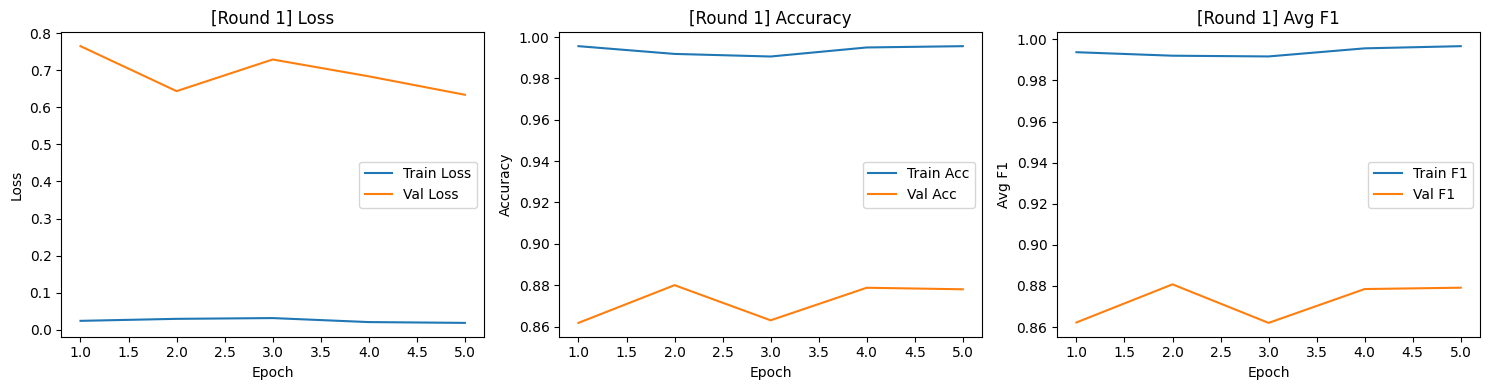


[AL Round 2/5] — Labeled samples: 1700

Epoch 1/5


Train — Loss: 0.1163 | Acc: 0.9606 | Avg F1: 0.9593
Val   — Loss: 0.7518 | Acc: 0.8565 | Avg F1: 0.8600

Epoch 2/5


Train — Loss: 0.0586 | Acc: 0.9782 | Avg F1: 0.9772
Val   — Loss: 0.7092 | Acc: 0.8722 | Avg F1: 0.8760

Epoch 3/5


Train — Loss: 0.0451 | Acc: 0.9876 | Avg F1: 0.9906
Val   — Loss: 0.6947 | Acc: 0.8675 | Avg F1: 0.8707

Epoch 4/5


Train — Loss: 0.0123 | Acc: 0.9988 | Avg F1: 0.9991
Val   — Loss: 0.6272 | Acc: 0.8865 | Avg F1: 0.8884

Epoch 5/5


Train — Loss: 0.0094 | Acc: 0.9994 | Avg F1: 0.9990
Val   — Loss: 0.6214 | Acc: 0.8878 | Avg F1: 0.8896


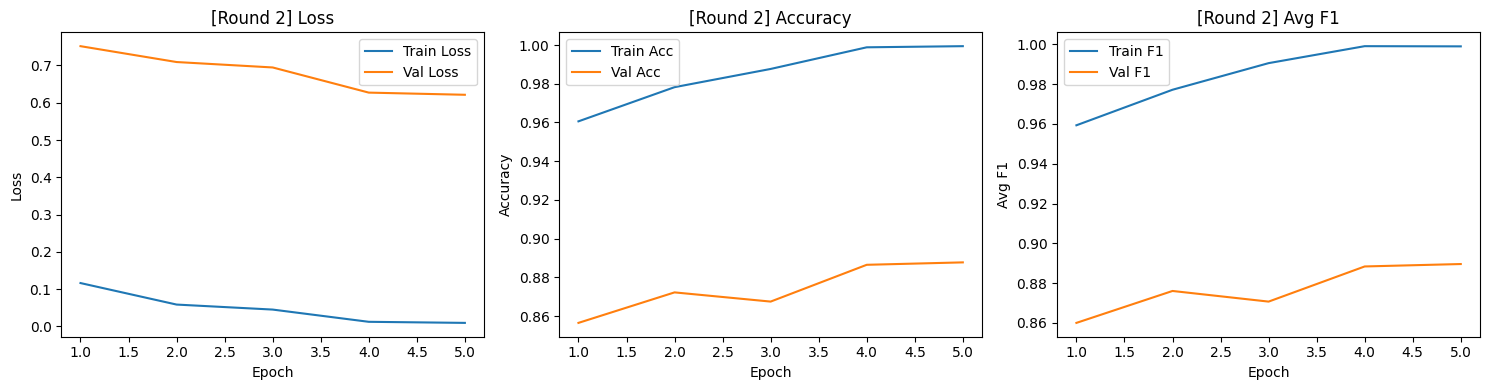


[AL Round 3/5] — Labeled samples: 1800

Epoch 1/5


Train — Loss: 0.0904 | Acc: 0.9656 | Avg F1: 0.9638
Val   — Loss: 0.8229 | Acc: 0.8678 | Avg F1: 0.8567

Epoch 2/5


Train — Loss: 0.0576 | Acc: 0.9844 | Avg F1: 0.9829
Val   — Loss: 0.8933 | Acc: 0.8257 | Avg F1: 0.8347

Epoch 3/5


Train — Loss: 0.0506 | Acc: 0.9839 | Avg F1: 0.9790
Val   — Loss: 0.7246 | Acc: 0.8655 | Avg F1: 0.8655

Epoch 4/5


Train — Loss: 0.0418 | Acc: 0.9839 | Avg F1: 0.9825
Val   — Loss: 0.5950 | Acc: 0.8855 | Avg F1: 0.8830

Epoch 5/5


Train — Loss: 0.0208 | Acc: 0.9944 | Avg F1: 0.9932
Val   — Loss: 0.6873 | Acc: 0.8802 | Avg F1: 0.8796


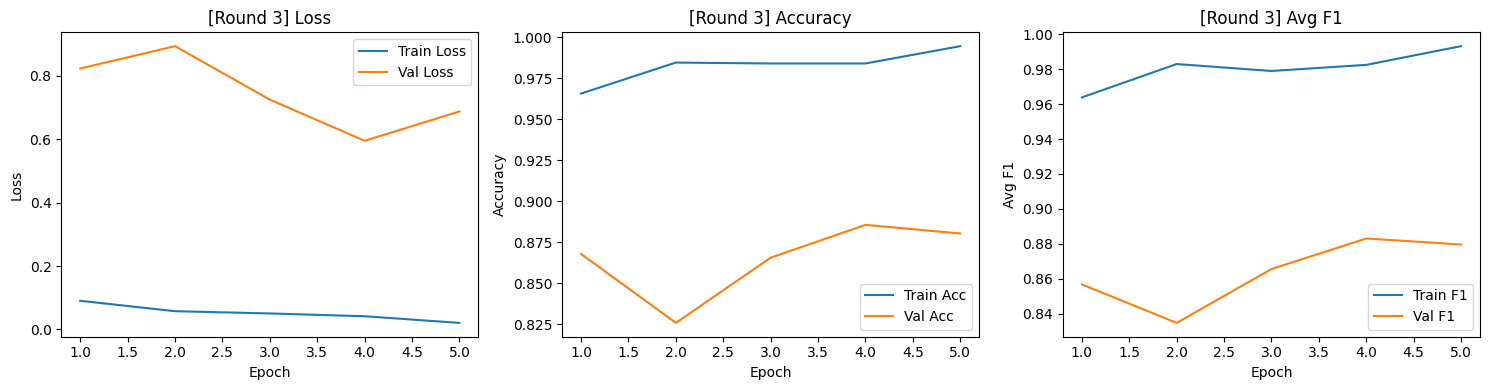


[AL Round 4/5] — Labeled samples: 1900

Epoch 1/5


Train — Loss: 0.1001 | Acc: 0.9705 | Avg F1: 0.9724
Val   — Loss: 0.6025 | Acc: 0.8778 | Avg F1: 0.8810

Epoch 2/5


Train — Loss: 0.0557 | Acc: 0.9847 | Avg F1: 0.9863
Val   — Loss: 0.5931 | Acc: 0.8842 | Avg F1: 0.8834

Epoch 3/5


Train — Loss: 0.0269 | Acc: 0.9911 | Avg F1: 0.9922
Val   — Loss: 0.6107 | Acc: 0.8882 | Avg F1: 0.8887

Epoch 4/5


Train — Loss: 0.0118 | Acc: 0.9989 | Avg F1: 0.9992
Val   — Loss: 0.6291 | Acc: 0.8928 | Avg F1: 0.8936

Epoch 5/5


Train — Loss: 0.0096 | Acc: 0.9984 | Avg F1: 0.9988
Val   — Loss: 0.6062 | Acc: 0.8900 | Avg F1: 0.8901


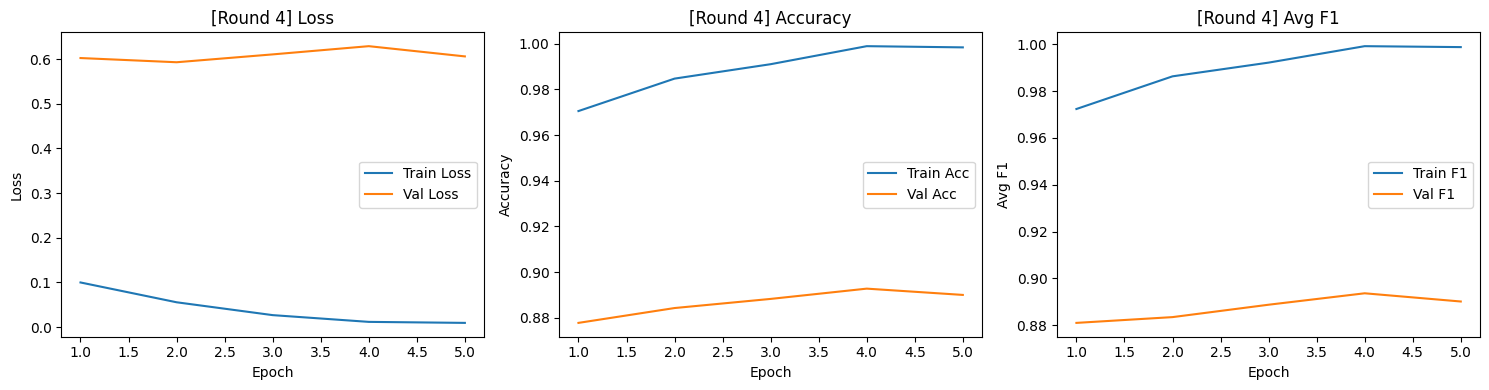


[AL Round 5/5] — Labeled samples: 2000

Epoch 1/5


Train — Loss: 0.0944 | Acc: 0.9665 | Avg F1: 0.9645
Val   — Loss: 0.8024 | Acc: 0.8702 | Avg F1: 0.8734

Epoch 2/5


Train — Loss: 0.0851 | Acc: 0.9720 | Avg F1: 0.9697
Val   — Loss: 0.8959 | Acc: 0.8595 | Avg F1: 0.8570

Epoch 3/5


Train — Loss: 0.0365 | Acc: 0.9880 | Avg F1: 0.9879
Val   — Loss: 0.6002 | Acc: 0.8862 | Avg F1: 0.8849

Epoch 4/5


Train — Loss: 0.0191 | Acc: 0.9950 | Avg F1: 0.9947
Val   — Loss: 0.6208 | Acc: 0.8898 | Avg F1: 0.8895

Epoch 5/5


Train — Loss: 0.0102 | Acc: 0.9990 | Avg F1: 0.9992
Val   — Loss: 0.6300 | Acc: 0.8858 | Avg F1: 0.8851


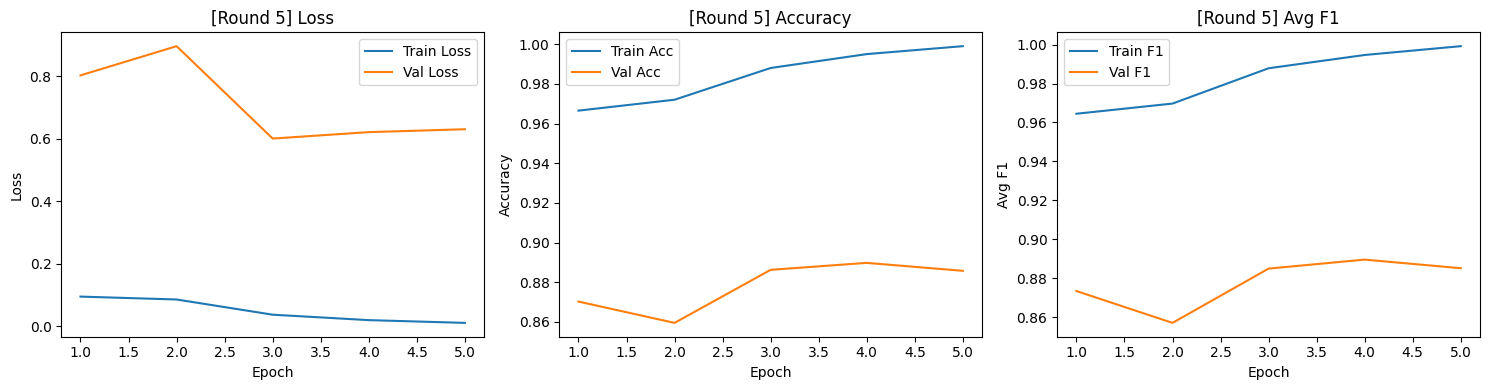

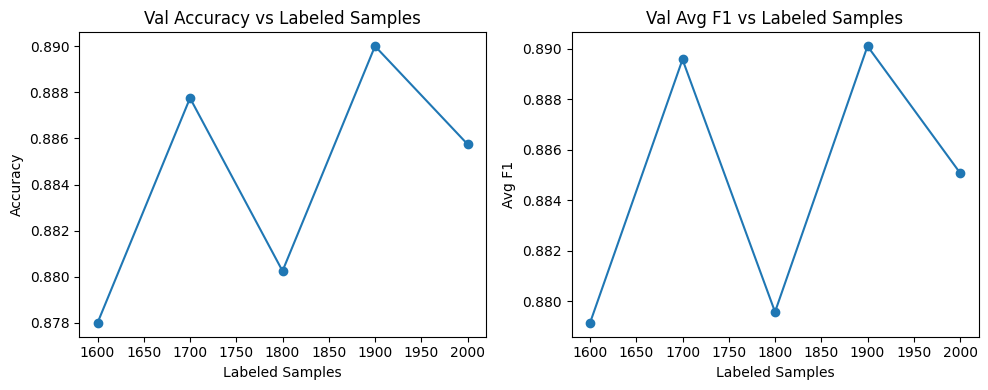

In [76]:
history = active_learning_loop(model, labeled_dataset, unlabeled_dataset, val_dataset, strategy="entropy", device=device, iters=5, query_size=100, epochs=5)

with open("/kaggle/working/history_entropy.pkl", "wb") as f:
    pickle.dump(history, f)
